In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, numpy as np, pandas as pd
sn.set_context('notebook')

# Markov chain Monte Carlo (MCMC) methods

In the previous notebook we saw how Monte Carlo (MC) methods can be used to draw representative samples from difficult distributions and also to integrate functions that have no analytical solution. However, we also saw than many basic MC techniques become inefficient for high-dimensional problems.

There are many ways in which simple MC algorithms can be improved, but in this notebook we're going to focus on just one very powerful sub-set of MC methods: **Markov chain Monte Carlo (MCMC)**.

One characteristic of the MC methods discussed previously is that they rely on **independent random sampling**. This independence is a useful property, but it also leads to inefficiencies. Ultimately, we want to draw a representative sample from some complex distribution, $f(x)$, which might be e.g. our posterior distribution from a model calibration exercise. To do this, we need to draw more samples from regions of $f(x)$ with high probability density and fewer samples from regions with low probability density. Because standard MC approaches use independent sampling, the algorithms do not "know" when they're in high density portions of the parameter space. To improve matters, we might construct an algorithm with a "memory" of its previous samples, which it could use identify relatively high density areas compared to where it's been previously. Having identified such a region, the algorithm might decide to draw more samples from that part of the parameter space, thereby producing a representative sample from $f(x)$ more quickly.  

This idea introduces a few new problems. In particular, if we choose the next sample, $x_{i+1}$, based on the current sample, $x_i$, then the samples will be auto-correlated, which means that each individual sample contains less new information about $f(x)$ than if the samples were independent. On the other hand, this approach may be more efficient than an independent sampling strategy, because the algorithm will focus on the most important regions of the parameter space. We may therefore be able to get away with fewer samples, even if the information content of each one is reduced.

## 1. Markov chains

A [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) is a random process where the next state of the chain depends *only* on the current state and not on the sequence of events that preceded it. The most commonly used analogy for a Markov chain is that it's like a drunken man staggering along a street: his location after his next step is determined by his current location, plus a random perturbation. He therefore takes a **random walk** through the landscape.

At the risk of stretching this analogy too far, the Markov chains that we will use are more like drunken *mountaineers*, because they will also possess a desire or tendency to move *uphill*, towards regions of higher probability density. However, it is important to note  that they do not *always* move uphill (sometimes they will descend or contour a bit), but in general they like to spend more time on the high ground than down in the valleys. 

Note that if our "mountaineers" *did* always move uphill in our probability landscape we would actually be constructing an *optimiser* (and an inefficient one at that) rather than a sampler. If we just want to find the highest point in our landscape there are plenty of better options out there - see the section on Maximum Likelihood Estimation at the end of notebook 2, for example. However, we don't want an optimiser; we want to draw a representative sample from our target distribution, and this means our "mountaineers" must occasionally go down to sample from the low probability "valleys", as well as spending most of their time on the high probability "mountain tops".

## 2. Brief reminder on rejection sampling

In the last notebook we discussed **non-uniform rejection sampling**, where we introduced a function, $mQ(x)$, which we know to be greater than $f(x)$ everywhere in our region of interest. We then drew independent samples, $x_i$, from $Q(x)$ and accepted them as samples from $f(x)$ if

$$y_i \leq f(x_i) \qquad where \qquad y_i \sim U(0, mQ(x_i))$$

In other words, where the $y_i$ are drawn from a uniform distribution between 0 and $mQ(x_i)$. 

Before we move on, we will first write this acceptance rule in a slightly different way. Drawing a value from a uniform distribution between 0 and some constant, $\alpha$, is the same as drawing from a uniform distribution between 0 and 1 and then multiplying by $\alpha$:

$$U(0, mQ(x_i)) = mQ(x_i) \times U(0,1)$$

Therefore we accept when 

$$y_i \leq \frac{f(x_i)}{mQ(x_i)} \qquad where \qquad y_i \sim U(0,1)$$

This gives exactly the same result as before, but this time we calculate the ratio, $\alpha = \frac{f(x_i)}{mQ(x_i)}$, and we also draw a random number, $y_i$, uniformly from the range between 0 and 1. If $y_i \leq \alpha$ then the point $x_i$ is accepted as a sample from $f(x)$.

## 3. The Metropolis algorithm

The most basic MCMC algorithm is the **[Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)**, which is both remarkably simple and extremely powerful. The algorithm proceeds as follows:

1. Begin at an arbitrary point, $x_0$, within the parameter space. <br><br>

2. Choose an arbitrary distribution, $Q(x)$, for determining the random component of the step. This is called the **jump** or **proposal** distribution and for the Metropolis algorithm it must be **symmetric**. In most cases it is chosen to be **Gaussian**. The jump distribution is centred on the current location, $x_i$, and provides a probability distribution for selecting a candidate location for the next step, $x_{i+1}$. If the distribution is Gaussian then points closer to $x_i$ are more likely to be chosen as candidates than those further away.<br><br>

3. Use the proposal distribution to generate a candidate location for the next point in the chain, $x_{i+1}$. <br><br>

4. Evaluate $\alpha = \frac{f(x_{i+1})}{f(x_i)}$.

    * If $\alpha \geq 1$ then $x_{i+1}$ has a higher probability density than $x_i$, so because our "drunken mountaineers" like to move uphill, we accept $x_{i+1}$ as the next step in the Markov chain and move to that location.<br><br>
    
    * If $\alpha < 1$, draw a value, $y_i$ from a uniform distribution between 0 and 1. Accept $x_{i+1}$ as the next step in the chain if $y_i \leq \alpha$, otherwise reject $x_{i+1}$ and remain at $x_i$ for this step. Note that this rejection rule is essentially the same as for **rejection sampling** (see above), except here we're applying it to subsequent steps in a Markov chain. This rule means that, when $\alpha < 1$, the probability of the chain moving "downhill" to an area with lower probability density is $\alpha$. <br><br>
    
5. Return to step 3 and repeat.

It can be proved that, as the number of steps in the chain becomes large, the distribution of samples in the chain converges on the distribution of $f(x)$. Although I'm not going to reproduce the proof here, I hope you can see intuitively why it works:

* The Markov chain takes a random walk through the probability landscape defined by $f(x)$. The chain has a tendency to move uphill, because when the newly proposed point has higher probability density than the current point the proposal is *always* accepted. This means that if the chain finds itself in a region with low probability density, it will rapidly move towards a more probable area.  <br><br>

* The proposed point is also *sometimes* accepted even when its probability density is lower, so the algorithm can still move "downhill". If the probability density at $x_{i+1}$ is only half that at $x_i$ then, in order to draw a representative sample, we want roughly twice as many samples from $x_i$ as from $x_{i+1}$. According to the acceptance rule for the Metropolis algorithm, the probability of accepting $x_{i+1}$ as the next point in the chain is $\frac{f(x_{i+1})}{f(x_i)} = 0.5$. Over a large number of steps, we therefore expect the chain to return roughly half as many samples from $x_{i+1}$ as from $x_i$, exactly as desired. In this way, the chain has a tendency to move towards high-density regions of $f(x)$, while only visiting lower density regions in proportion to their relative density.

Let's use the Metropolis algorithm to draw a sample from the same function used as an example in notebook 3:

$$f(x) = (\sin^2 x + 0.3)e^{-0.5x^2}$$

Note that, as with the previous examples, we're only interested in determining the *shape* of the function $f(x)$ (i.e. evaluating it to within a multiplicative constant). Note also that we need to choose a **starting point**, $x_0$, for our Markov chain as well as a **proposal distribution**, $Q(x)$. In the example below we arbitrarily choose $x_0 = 0$ and $Q(x)$ to be a Gaussian distribution with standard deviation 1. We'll return to these assumptions later.

Acceptance rate: 71.0%


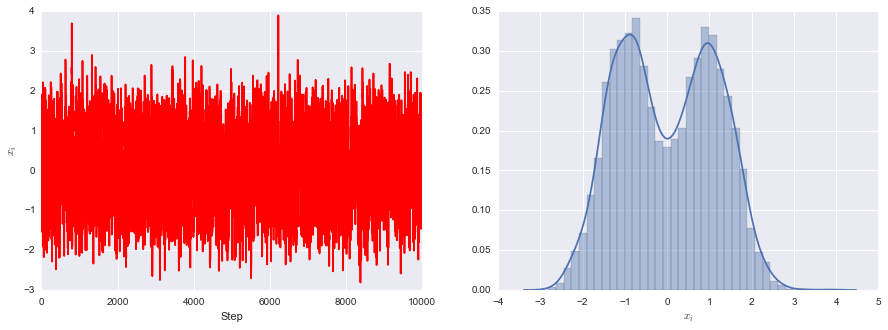

In [2]:
def f(x):
    """ This is the function we want to integrate.
    """
    return (np.sin(x)**2 + 0.3)*np.exp(-0.5*x**2)

def metropolis(x_0, sigma, n):
    """ Simple implementation of the Metropolis algorithm. Returns
        chain and acceptance rate
            
            x_0 is the starting point for the chain
            sigma is the std. dev. of the proposal distribution
            n is the number of steps to take
    """
    # Counter for number of accepted jumps
    n_accept = 0.

    # Create a chain and add x_0 to it
    chain = [x_0,]

    # Draw n random samples from Gaussian proposal distribution to use for 
    # determining step size
    jumps = np.random.normal(loc=0, scale=sigma, size=n)

    # Draw n random samples from U(0, 1) for determining acceptance
    y_i = np.random.uniform(low=0, high=1, size=n)

    # Random walk
    for step in xrange(1, n):
        # Get current position of chain
        x = chain[-1]

        # Get a candidate for x_i+1 based on x_i and jump
        cand = x + jumps[step]

        # Calculate alpha
        alpha = f(cand)/f(x)

        # Accept candidate if y_i <= alpha
        if y_i[step] <= alpha:
            x = cand
            n_accept += 1
        chain.append(x)

    # Acceptance rate
    acc_rate = (100*n_accept/n)
    
    return [chain, acc_rate]

def plot_metropolis(chain, acc_rate):
    """ Plot results of Metropolis algorithm.
    """
    print 'Acceptance rate: %.1f%%' % acc_rate

    # Plot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plot chain
    axes[0].plot(range(len(chain)), chain, 'r-')
    axes[0].set_xlabel('Step')
    axes[0].set_ylabel('$x_i$')

    # Plot normalised histogram of accepted values
    sn.distplot(chain, ax=axes[1])
    axes[1].set_xlabel('$x_i$')
    plt.show()

x_0 = 0 # Starting location
sigma = 1 # Std. dev. for proposal distribution
n = 10000  # Number of steps to take

chain, acc_rate = metropolis(x_0, sigma, n)
plot_metropolis(chain, acc_rate)

The plot on the left above illustrates the random walk taken by our Markov chain through the (one-dimensional) parameter space of $f(x)$. You can see that the chain very occasionally explores values towards the extremes of the distribution (such as $\pm 3$), but spends the vast majority of its time in the region between about $\pm 1$, which is where most of the probability desnity of $f(x)$ is located. 

Of course, in the example above we chose $x_0 = 0$, which is already a pretty good starting position for our chain - it's located right in the middle of our target distribution. What if we start from somewhere that is far away from the high density region of $f(x)$? In the example below, I've chosen $x_0 = -10$ and I've also reduced the number of samples to just 1000 to make it easier to see the evolution of the chain.

Acceptance rate: 70.1%


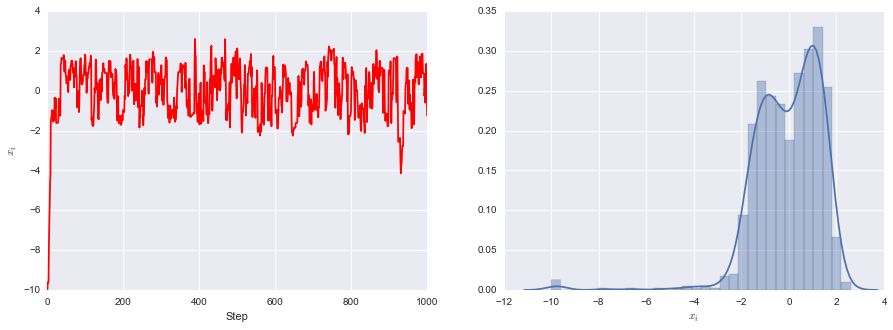

In [3]:
x_0 = -10 # Starting location
sigma = 1 # Std. dev. for proposal distribution
n = 1000  # Number of steps to take

chain, acc_rate = metropolis(x_0, sigma, n)
plot_metropolis(chain, acc_rate)

As you can see, regardless of the starting point, the chain moves rapidly back towards the region of high probability density and then remains in that general area, sampling from the distribution. In high-dimensional parameter spaces, this behaviour is one of the great advantages of MCMC methods over traditional MC alternatives: the Markov property enables the chain to explore the parameter space in a more intelligent way, by focusing its attention on each region in proportion to its probability density.

Note, however, that by choosing a poor starting location, the early part of the chain (roughly the first 50 or so steps in the example above) is not representative of rest of the sample. From about step 50 onwards, the general position of the chain is stable and we say that it has **converged** on the target distribution. Until this happens, we cannot be sure that the chain is returning samples from the target, so it is usual to discard the early portion of the chain, which is called the **burn-in** period. The burn-in period is the time it takes the chain to "forget" about it's starting point (which is arbitrary) and start returning representative samples from the target distribution.

Defining convergence rigorously turns out to be quite difficult, but fortunately it's usually obvious from trace plots, as in the example above. An additional step that is often taken after discarding the burn-in is to select only every $k th$ element from the converged chain. This is called **thinning** and is done to reduce auto-correlation in the series of samples used to represent $f(x)$.

Acceptance rate: 70.5%


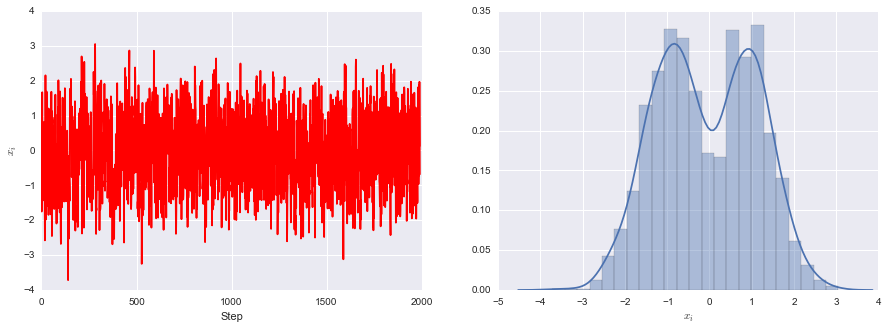

In [4]:
x_0 = -10    # Starting location
sigma = 1    # Std. dev. for proposal distribution
n = 10000    # Number of steps to take

burn_in = 50 # Number of steps to discard at start
thin = 5     # Keep only every "thin" steps

chain, acc_rate = metropolis(x_0, sigma, n)

# Discard burn-in and thin, then plot
plot_metropolis(chain[burn_in::thin], acc_rate)

## 4. Convergence efficiency

As noted above, in addition to choosing the starting location for our Markov chain, to run the Metropolis algorithm we must also choose a proposal distribution. In the example above we chose a Gaussian distribution with standard deviation 1, but would other distributions have worked just as well?

The good news is that the Metropolis algorithm is **guaranteed** to converge on the true distribution of $f(x)$, regardless of the proposal distribution chosen. This is a remarkable result: no matter how complex the target distribution, we can choose *any* symmetrical proposal distribution and be confident that the algorithm will eventually yield a representative sample of our target function. The downside is that the algorithm is **not** guaranteed to converge within a **practically useful time frame**.

In the example above, if we choose a small value for the standrad deviation, $\sigma$, the jump distribution is very narrow and pointed and the chain will take small steps through the probability landscape (because the probability of stepping far away from the current position will be small). As a result, it may take a long time to thoroughly explore the space. On the other hand, if we make $\sigma$ large the chain will take long strides across the landscape. If the bulk of the target function, $f(x)$, happens to be confined to a fairly small part of the parameter space (which is often the case), this may result in the chain repeatedly jumping away from the high density region of interest, thus reducing the sampling efficiency. In an ideal world we want to achieve a compromise between these two extremes. This is sometime referred to as the **[Goldilocks principle](https://www.google.co.uk/search?q=goldilocks%20MCMC&gws_rd=ssl#q=goldilocks+principle+MCMC)**: we want to find a step size that is not too large, not too small, but *just right*.

The code below is the same as that above, but this time using $\sigma = 10$ instead of $\sigma = 1$. We can immediately see that, at least for this very simple example, both choices appear to converge and produce a pretty good approximation of our target function, which is reassuring. Note, however, the very different acceptance rates: about 70% in the first example versus around 14% in the second.

Acceptance rate: 13.4%


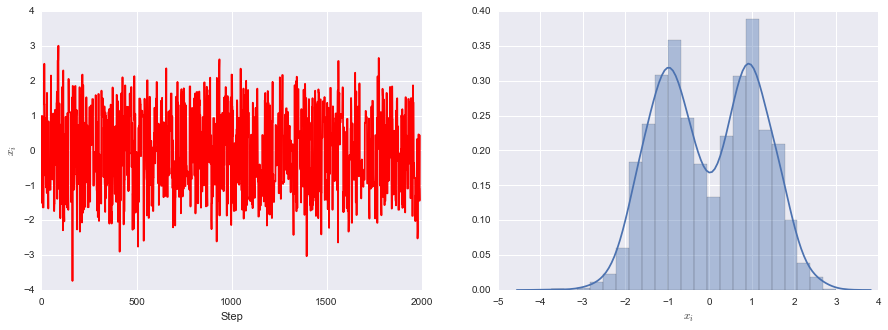

In [13]:
x_0 = -10    # Starting location
sigma = 10   # Std. dev. for proposal distribution
n = 10000    # Number of steps to take

burn_in = 50 # Number of steps to discard at start
thin = 5     # Keep only every "thin" steps

chain, acc_rate = metropolis(x_0, sigma, n)

# Discard burn-in and thin, then plot
plot_metropolis(chain[burn_in::thin], acc_rate)

So which is better? The true optimal acceptance rate will vary from problem to problem, according to the shape of the target function. However, without going into any details, it has been shown (e.g. [here](http://www.maths.lancs.ac.uk/~sherlocc/Publications/rwm.final.pdf)) that acceptance rates of around 20% are close to optimal for a broad range of problem classes. 23.4% is often quoted as the ideal value, but this is only true under particular assumptions. In practice, unless you have reason to believe otherwise, it is usually a good idea to aim for acceptance rates of between about 20% and 50%.

## 5. Adaptive algorithms

One way to achieve an acceptance rate of about 23% is to run the code above, manually experimenting with different values for $\sigma$ (you should find that a value of 6 is about right). This is laborious, however, and an attractive alternative is to let the proposal distribution (i.e. $\sigma$) **adapt** as the chain progresses. The basic idea is very simple: at various points during the random walk (e.g. every $n$ steps) we calculate the acceptance rate for the previous $n$ steps. If the value is too low we make $\sigma$ smaller, whereas if it's too high we make $\sigma$ bigger.

Unfortunately, this approach violates the Markovian property of our chain, because the position at the next step is now dependent on the previous $n$ steps, instead of only on the current position. The convergence of the Metropolis algorithm is only guaranteed for true Markov chains, so unless we take care over the way we introduce the "adaptation", we can no longer be sure that our algorithm will converge on the target function. One solution is to attempt to develop an adaptive algorithm for which convergence can be proved. This is usually difficult, but it has been done and there are R and Python packages available which implement such algorithms. A less efficient but very pragmatic alternative is to use a non-Markovian adaptation strategy during the burn-in phase to tune the proposal distribution. The adaptative component is then turned off and the "optimised" proposal distribution is used with the standard Metropolis algorithm to generate samples from the target distribution. This simple approach offers some of the advantages of a true adaptive MCMC algorithm without the need to worry about difficult convergence proofs. 